# Importing the Dataset

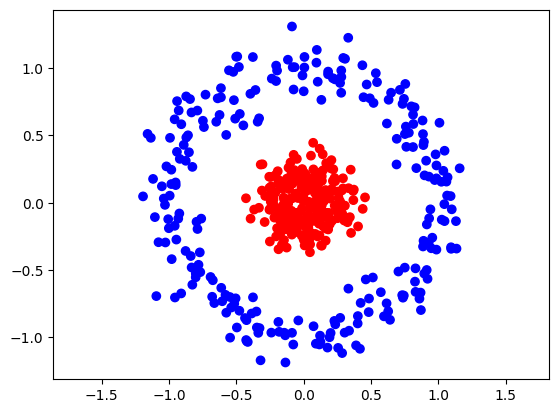

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles 
from sklearn.model_selection import train_test_split    
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors 
import matplotlib.pyplot as plt 
 
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"])) 
plt.axis('equal') 
plt.show() 

In [4]:
len(y_train)

375

I have changed label entries from {0,1} as {-1,1} by replacing 0s with -1s  

In [5]:
y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)
y_train

array([ 1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,
       -1,  1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,
        1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,
       -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
       -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,
        1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,
        1,  1, -1,  1,  1

# PART 1

## Importing necessary libraries 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Creating a class for Adaboost  

First, I have made the code so that it runs on taking decision stump as the weak learner as it is the most commonly used weak learner for adaboost

In [7]:
class AdaBoost:
    def __init__(self, weak_learner_factory=None, iter=200, eta=0.5): # Eta is hyperparameter initialsied to 0.5
        self.weak_learner_factory = weak_learner_factory # to initialize the weak learner
        self.models = [] # stores the weak learners in each iteration
        self.alphas = [] # stores the corresponding alphas in each iteration
        self.iter = iter
        self.eta = eta
        self.model_errors = []

    def alpha_calc(self, X_train, y_train, w):  # Calculates the alpha for each weak learner

        learner = self.weak_learner_factory()

        ## LDA and LinearSVC don't support sample_weight
        if isinstance(learner, LinearDiscriminantAnalysis or LinearSVC): 
            learner.fit(X_train, y_train)
        else:
            learner.fit(X_train, y_train, sample_weight=w)
        y_train_pred = learner.predict(X_train)

        error = np.sum(w[(y_train_pred != y_train)])
        if error == 0:
            error = 1e-10  # Prevent division by zero

        alpha = 0.5 * np.log((1 - error) / error) * self.eta
        self.alphas.append(alpha)
        self.models.append(learner)
        return learner, alpha

    def update_weights(self, w, y_train_pred, y_train, alpha):
        w = w * np.exp(-alpha * y_train * y_train_pred) ## From formula given to update the weights 
        return w / np.sum(w) ## To normalise the weights

    def fit(self, X_train, y_train):
        n_samples = len(y_train)
        w = np.ones(n_samples) / n_samples
        f = np.zeros(n_samples)

        for i in range(self.iter):
            learner, alpha = self.alpha_calc(X_train, y_train, w) 
            y_train_pred = learner.predict(X_train)
            w = self.update_weights(w, y_train_pred, y_train, alpha)
            
            # Plot decision boundary after each iteration on the same plot
            self.plot_decision_boundary(X_train, y_train, iteration=i)
        
        plt.title('Decision Boundaries After Each Iteration')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.show()

        return self

    def predict(self, X_test): ## Does the prediction
        final_pred = np.zeros(X_test.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            pred = model.predict(X_test)
            final_pred += alpha * pred
        return np.sign(final_pred)
    
    def score(self, X_test, y_test): ## Here I have taken accuracy score as the metric
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)
    
    # Required for GridSearchCV
    def get_params(self, deep=True):
     return {"weak_learner_factory": self.weak_learner_factory, "iter": self.iter, "eta": self.eta}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    ## To plot the decision boundary
    def plot_decision_boundary(self, X, y, iteration):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the boundary line (contour) for each iteration
        plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors=['black'], alpha=0.6)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Paired)

    def plot_final_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('lightgreen', 'lightyellow')))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Paired)
        plt.title('Final Decision Boundary')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.show()


I have used GridSearchCV to tune the hyperparameter eta

Fitting 5 folds for each of 9 candidates, totalling 45 fits


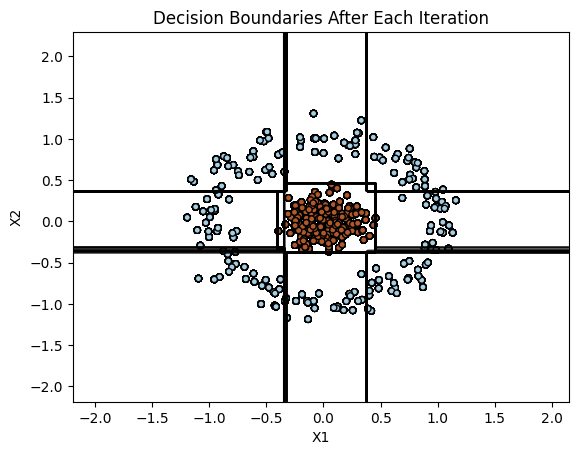

{'eta': 0.4}
Score :               precision    recall  f1-score   support

          -1       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        64

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



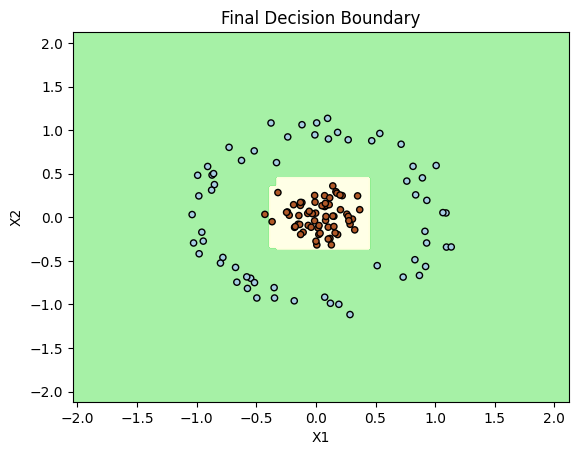

In [8]:
# Instantiate AdaBoost with decision stumps as weak learners
from sklearn.model_selection import GridSearchCV

param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: DecisionTreeClassifier(max_depth=1), iter=50)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")
# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

You can see that the algorithm works with a performance accuracy of 0.99

# PART 2


Now I had run the same code for the expected set of weak learners. 

## DECISION STUMP

Fitting 5 folds for each of 9 candidates, totalling 45 fits


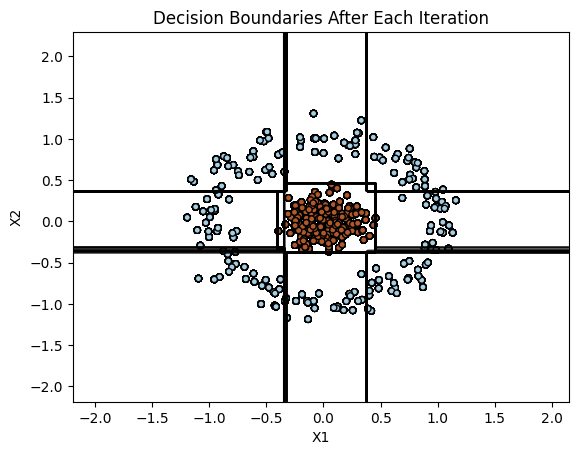

{'eta': 0.4}
Score :               precision    recall  f1-score   support

          -1       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        64

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



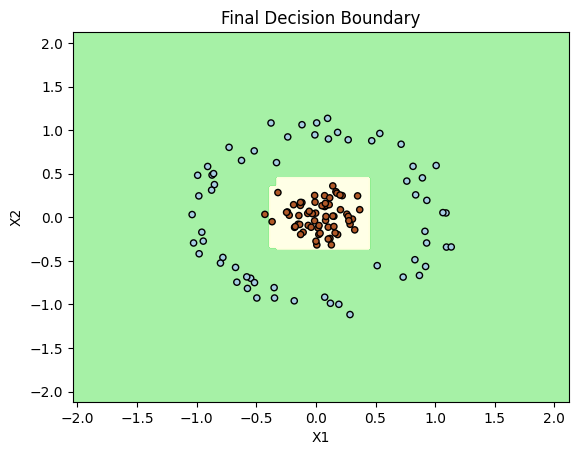

In [9]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: DecisionTreeClassifier(max_depth=1), iter=50)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

## Decision Tree (max_depth=3)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


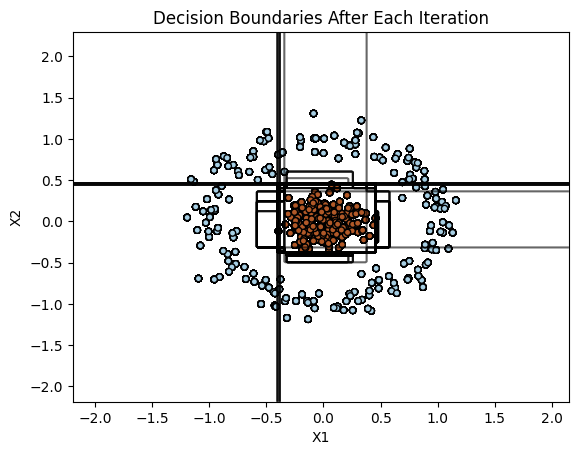

{'eta': 0.2}
Score :               precision    recall  f1-score   support

          -1       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        64

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



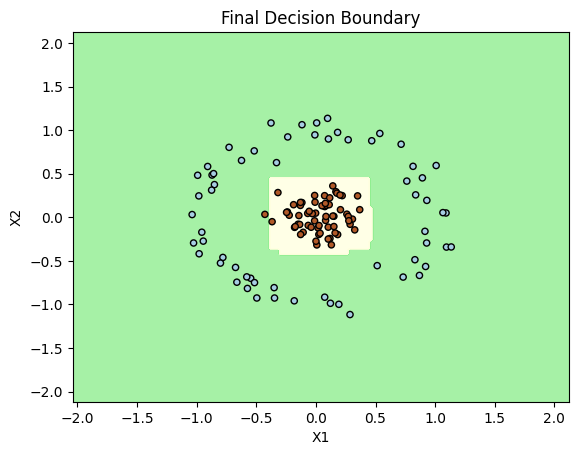

In [10]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: DecisionTreeClassifier(max_depth=3), iter=50)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

## Logreg

Fitting 5 folds for each of 9 candidates, totalling 45 fits


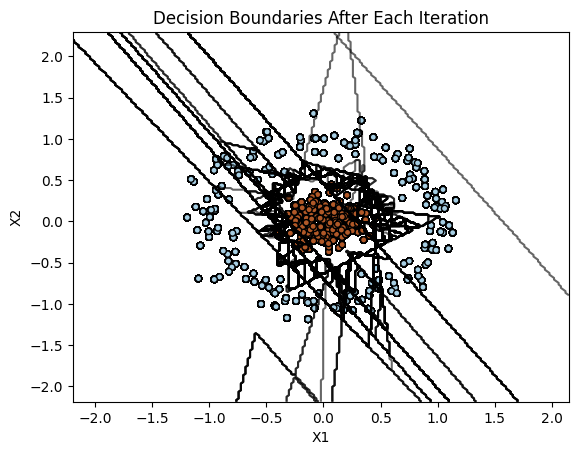

{'eta': 0.9}
Score :               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        64

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



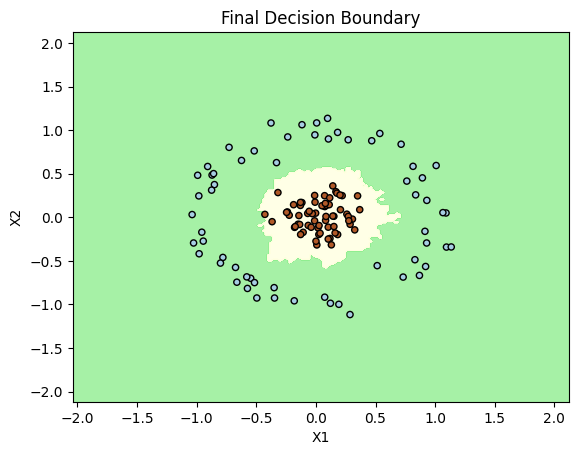

In [11]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: LogisticRegression(), iter=200)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

## Linear SVM

Fitting 5 folds for each of 9 candidates, totalling 45 fits


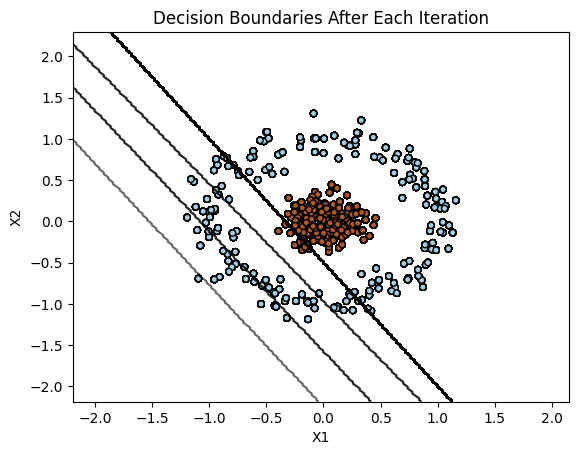

{'eta': 0.9}
Score :               precision    recall  f1-score   support

          -1       0.93      0.46      0.62        61
           1       0.65      0.97      0.78        64

    accuracy                           0.72       125
   macro avg       0.79      0.71      0.70       125
weighted avg       0.79      0.72      0.70       125



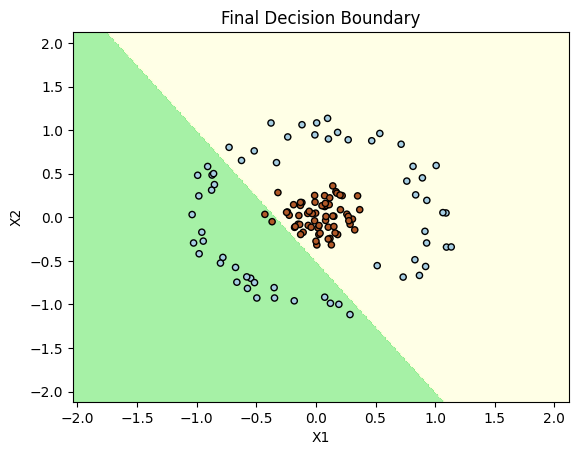

In [12]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: LinearSVC(C=0.01), iter=100)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

## LDA

Fitting 5 folds for each of 9 candidates, totalling 45 fits


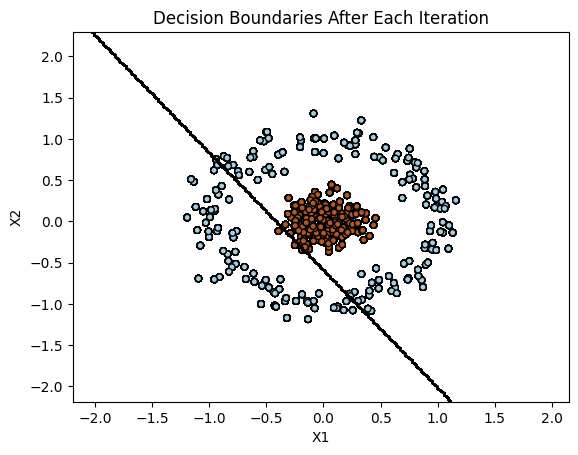

{'eta': 0.1}
Score :               precision    recall  f1-score   support

          -1       1.00      0.46      0.63        61
           1       0.66      1.00      0.80        64

    accuracy                           0.74       125
   macro avg       0.83      0.73      0.71       125
weighted avg       0.83      0.74      0.71       125



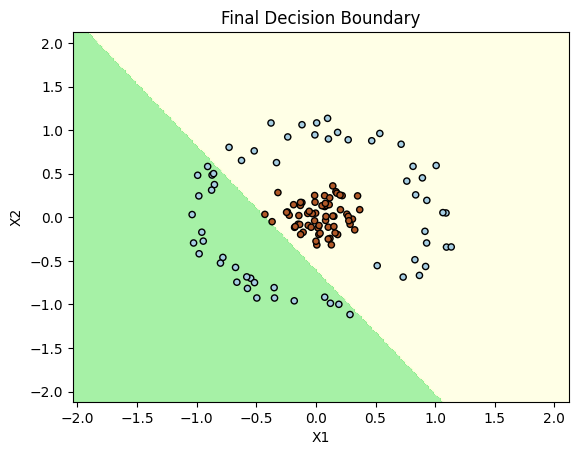

In [13]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: LinearDiscriminantAnalysis(), iter=100)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

## Observation 

1. You can see that the written adaboost algorithm works well for DecisionTreeClassifier and LogisticRegression but not so for LinearSVC and LDA. 

2. This makes sense because sample_weights can be given as input to DecisionTree and Logreg classifiers (Input parameter in their .fit function) but not for the latter learners. 

3. So, for the other learners, the updated weights were not given as inputs in subsequent iterations and therefore there is only a linear boundary coming when LDA and LinearSVC were used.

4. We have to modify the code so that the weights are manually given as input to the algorithm. 

5. This can be done by modifying the dataset according to the weights and then directly giving these 'weighted' dataset as input to these classifiers. This is the modification done in the following code

## Modified adaboost 

In [24]:
class modified_AdaBoost:
    def __init__(self, weak_learner_factory=None, iter=200, eta=0.5):
        self.weak_learner_factory = weak_learner_factory
        self.models = []
        self.alphas = []
        self.iter = iter
        self.eta = eta
        self.model_errors = []

    def alpha_calc(self, X_train, y_train, w):

        #################### Modification Done ######################
        indices = np.arange(len(X_train))
        replicated_indices = np.random.choice(indices, size=len(X_train), p=w)

        # Create the weighted dataset by selecting samples based on replicated indices
        X_weighted = X_train[replicated_indices]
        y_weighted = y_train[replicated_indices]

        #################### Modification Done ######################
        

        learner = self.weak_learner_factory()
        learner.fit(X_weighted, y_weighted)
        y_train_pred = learner.predict(X_train)

        error = np.sum(w[(y_train_pred != y_train)])
        if error == 0:
            error = 1e-10  # Prevent division by zero

        alpha = 0.5 * np.log((1 - error) / error) * self.eta


        self.alphas.append(alpha)
        self.models.append(learner)
        return learner, alpha

    def update_weights(self, w, y_train_pred, y_train, alpha):
        w = w * np.exp(-alpha * y_train * y_train_pred)
        return w / np.sum(w)

    def fit(self, X_train, y_train):
        n_samples = len(y_train)
        w = np.ones(n_samples) / n_samples
        f = np.zeros(n_samples)

        for i in range(self.iter):
            learner, alpha = self.alpha_calc(X_train, y_train, w)
            y_train_pred = learner.predict(X_train)
            w = self.update_weights(w, y_train_pred, y_train, alpha)
            
            # Plot decision boundary after each iteration on the same plot
            self.plot_decision_boundary(X_train, y_train, iteration=i)
        
        plt.title('Decision Boundaries After Each Iteration')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.show()

        return self

    def predict(self, X_test):
        final_pred = np.zeros(X_test.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            pred = model.predict(X_test)
            final_pred += alpha * pred
        return np.sign(final_pred)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)
    
    def get_params(self, deep=True):
     return {"weak_learner_factory": self.weak_learner_factory, "iter": self.iter, "eta": self.eta}

    # Required for GridSearchCV
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def plot_decision_boundary(self, X, y, iteration):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the boundary line (contour) for each iteration
        plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors=['black'], alpha=0.6)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Paired)

    def plot_final_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('lightgreen', 'lightyellow')))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Paired)
        plt.title('Final Decision Boundary')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


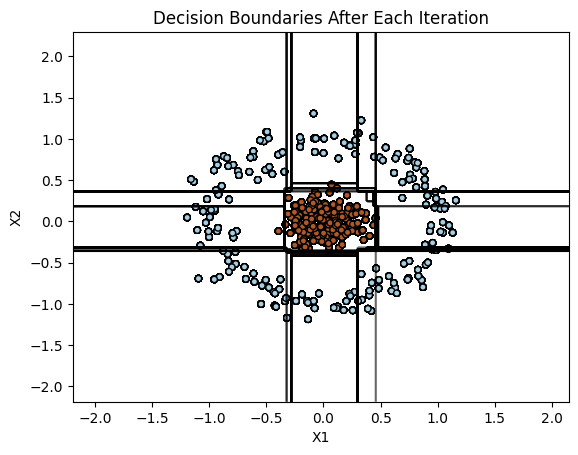

{'eta': 0.4}
Score :               precision    recall  f1-score   support

          -1       0.97      1.00      0.98        61
           1       1.00      0.97      0.98        64

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



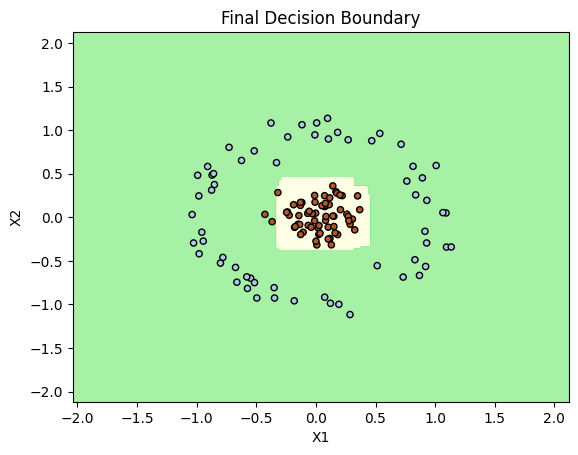

In [25]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = modified_AdaBoost(weak_learner_factory=lambda: DecisionTreeClassifier(max_depth=1), iter=100)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


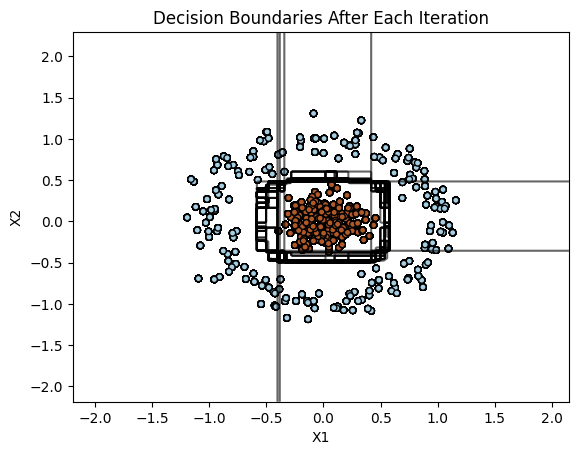

{'eta': 0.8}
Score :               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        64

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



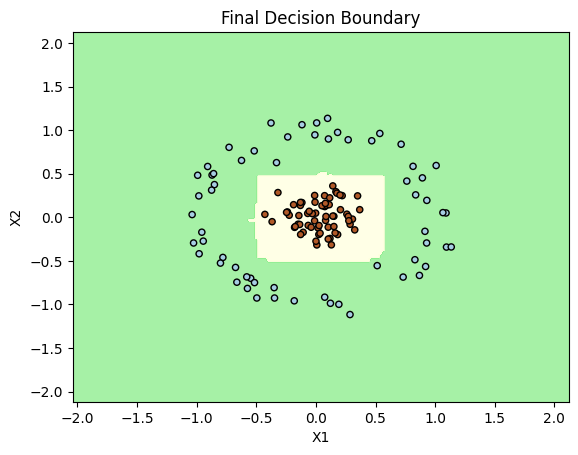

In [26]:
param_grid = {'eta': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = modified_AdaBoost(weak_learner_factory=lambda: DecisionTreeClassifier(max_depth=3), iter=50)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


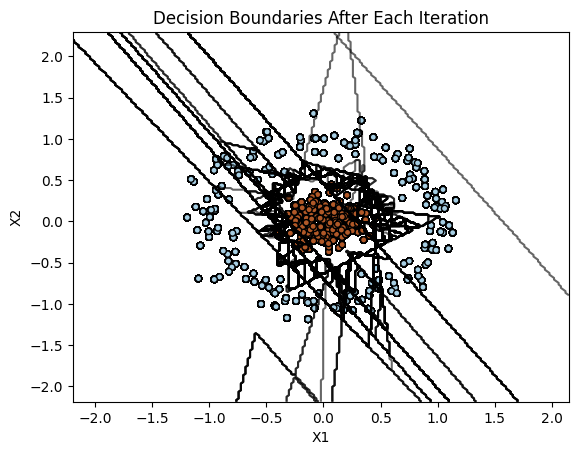

{'eta': 0.9}
Score :               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        64

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



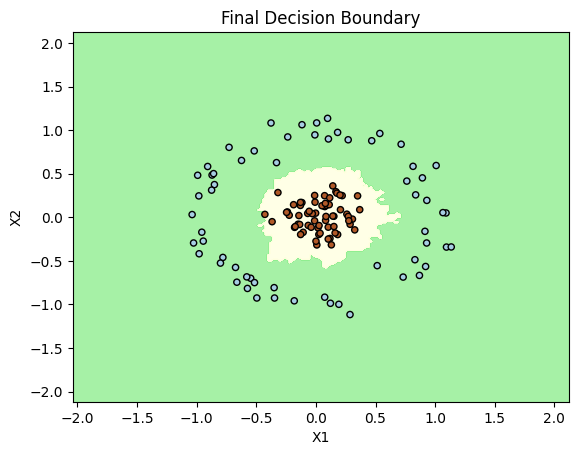

In [27]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = AdaBoost(weak_learner_factory=lambda: LogisticRegression(), iter=200)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


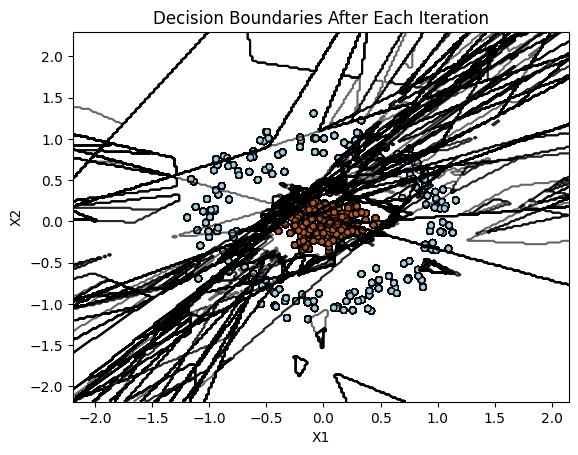

{'eta': 0.9}
Score :               precision    recall  f1-score   support

          -1       0.97      1.00      0.98        61
           1       1.00      0.97      0.98        64

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



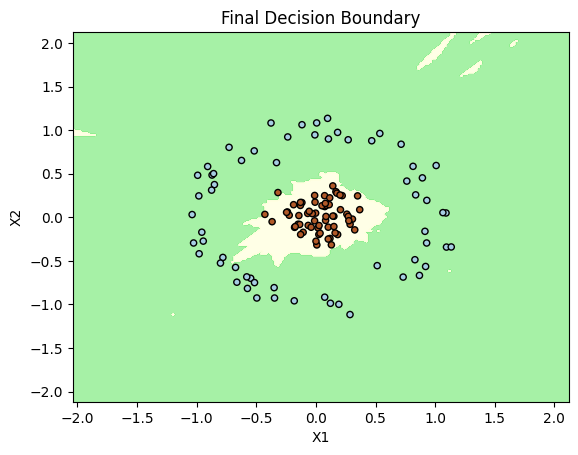

In [28]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = modified_AdaBoost(weak_learner_factory=lambda: LinearSVC(C=0.01), iter=200)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


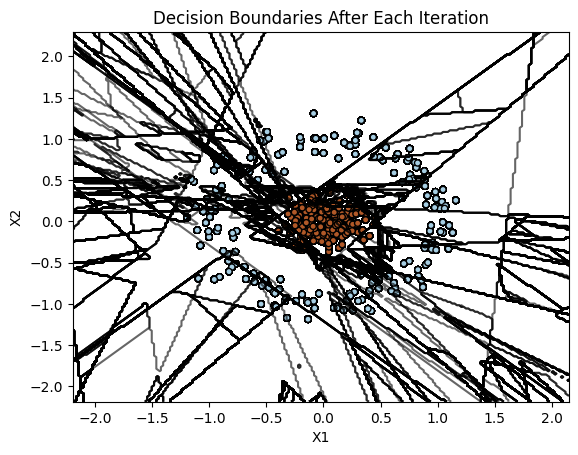

{'eta': 0.9}
Score :               precision    recall  f1-score   support

          -1       0.98      0.98      0.98        61
           1       0.98      0.98      0.98        64

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



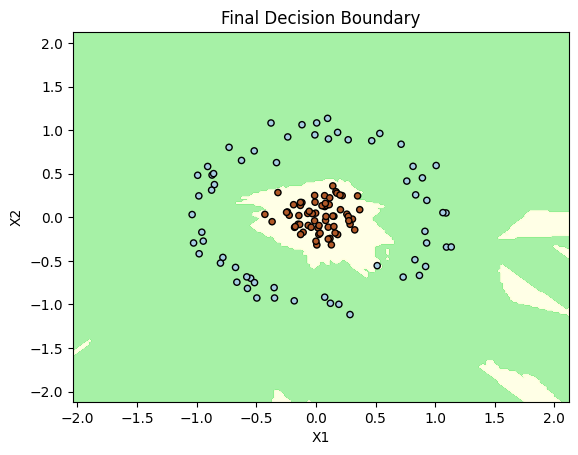

In [33]:
param_grid = {'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

ada = modified_AdaBoost(weak_learner_factory=lambda: LinearDiscriminantAnalysis(), iter=200)

grid_search = GridSearchCV(ada, param_grid, cv=5, n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_ada = grid_search.best_estimator_
# Fit the AdaBoost model and plot boundaries
#best_ada.fit_(X_train, y_train)

y_pred = best_ada.predict(X_test)
print(f"Score : {classification_report(y_test, y_pred)}")

# Plot the final decision boundary separately
best_ada.plot_final_boundary(X_test, y_test)

We can now see that the modified adaboost runs better byt taking LinearSVC and LDA as weak learners as we manually updated the weights. There is some error observed in the final decision boundary for these weak learners though. This may occur due to the randomness incurred in np.random.choice